In [1]:
import warnings
warnings.filterwarnings('ignore')
# this helps remove warnings which may deanonymize authors through pathnames.

In [2]:
import tqdm
from pprint import pprint
from scipy.optimize import linprog

In [3]:
from fairnessday_vs_linprog import (sample_ranking_bernoulli, get_fairness_day_dcg,
                                    sample_rankings, optimal_ranking, compare_fairness_day_with_linprog)
from evaluation import get_v
from sample_rankings_util import *
from linear_program import get_linprog_coeffs_all_permutations

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r'\usepackage{nicefrac}'


In [5]:
def plot_tradeoff(alphas, linprog_dcgs, fairness_day_dcgs, label_opt=True, label_fair=True, 
                  custom_xticks=False, 
                  special_xticks=None, marker='.'):
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(1, 1, 1)
    plt.rc('font', family='serif')
    plt.plot(alphas, linprog_dcgs, label=r'$\pi^{\textrm{\small LP}, \phi}$', marker=marker, linestyle='solid', color='k')
    plt.plot(alphas, fairness_day_dcgs, label=r'$\pi^{\textrm{\small Mix},\phi}$', marker=marker, linestyle='--', color='k')
    if custom_xticks:
        plt.xticks(alphas)
    style = dict(size=12, color='k') 
    if label_opt:
        plt.text(0.0-0.06, linprog_dcgs[0]-0.001, r'$\pi^*$', **style)
    if label_fair:
        plt.text(1.0+0.02, linprog_dcgs[-1], r'$\pi^{\textrm{\small TS}}$', **style)
    if special_xticks:
        plt.xticks([-0.1, 0.0, 0.2, 0.4, 0.6, 0.8, 6.0/7, 1.0, 1.1], 
                   [None, 0.0, 0.2, 0.4, 0.6, 0.8, r'$\nicefrac{6}{7}$',1.0, None])
        ax.axvline(6.0/7, ymin=0, ymax=linprog_dcgs[-3], linestyle=':', color='gray')
    plt.legend()
    plt.ylabel('U($\pi$)')
    plt.xlabel(r'$\phi$')
    plt.tight_layout()
    plt.show()


# Example 1 (Appendix)

Consider $n=3$ agents, namely $a, b$, and $c$.

Under $\Gamma$, their merits $v_a = 1$, $v_b \sim Bernoulli(1/2)$, and $v_c \sim Bernoulli(1/2)$ are drawn independently.

The position weights are $w_1 = 1, w_2 = 1$, and $w_3=0$. 
 

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


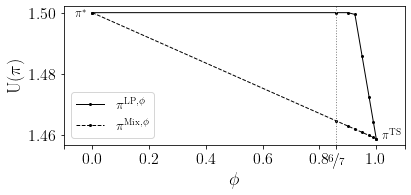

In [9]:
num_docs = 3
posterior_params = np.array([1.0, 0.5, 0.5])
v=[1, 1, 0]
phis=[0.0, 6.0/7.0, 0.9, 0.925, 0.95, 0.975, 0.99, 1.0]
linprog_dcgs = []
fairness_day_dcgs = []
coeffs = get_linprog_coeffs_all_permutations(posterior_params, 1.0, v)
for alpha in tqdm.tqdm(phis):
    res = linprog(coeffs['c'], coeffs['A_ub'], alpha*coeffs['b_ub'], coeffs['A_eq'], coeffs['b_eq'], coeffs['bounds'])
    linprog_dcgs.append(-res.fun)
    fairness_day_dcgs.append(get_fairness_day_dcg(posteriors, alpha, v=v, num_days=10000))
t_fairness_day_dcgs = [(1-alpha)*linprog_dcgs[0] + alpha*linprog_dcgs[-1] for alpha in alphas]
plot_tradeoff(alphas, linprog_dcgs, t_fairness_day_dcgs, 
              label_opt=True, label_fair=True,
              special_xticks=[[6.0/7.0], [r'$\nicefrac{6}{7}$']])
